In [1]:
import numpy as np
import matplotlib.pyplot as plt
from knn import KNNCalibrator
rng = np.random.default_rng(42)

def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5):
    """Vectorized paraboloid, mild noise; supports scalar or vector xi."""
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:
        xi = np.full(theta.shape[0], xi)
    elif xi.ndim == 2:
        xi = xi.ravel()
    y = A * x1**2 + B * x1 * x2 * (1.0 + xi) + C * (x2 + xi) ** 2
    y = y + 0.2 * np.random.randn(theta.shape[0])  # small noise
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])

def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))

def scatter_post(ax, theta, truth=None, title="", alpha=0.30, s=6, label="Posterior"):
    ax.scatter(theta[:,0], theta[:,1], s=s, alpha=alpha, label=label)
    if truth is not None:
        ax.scatter(truth[:,0], truth[:,1], c="r", marker="x", s=60, label="θ true cloud")
    ax.set_title(title); ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()



### Adaptive DB expansion for KNN-based calibration


A semi Bayesian procedure
1. generate $D^{sim} =\{x_i,y_i\}_{i=1}^{n_{s}}$ of simulated input-out pairs from a Sim model $M$ sampled according to $f_x(X)$ (prior)
2. gather $D^{emp} = \{y^{emp}_j\}_{k=1}^{n_{e}}$ of empirical samples from a real system
3. for each empirical vector $ y^{emp} \in D_{emp}$ find a set $\mathcal{K}(y^{emp})$ with the $k$ input generating the closest output responses $ \mathcal{K}(y) \subset D_{sim}$, such that, e.g., $\sum\limits_{(x,y)\in \mathcal{K}(y^{emp})}||y^{emp}_k - y||_2^2$ is minimized
4. combine data in a data set of input $ D_{cal} = \bigcup \limits_{y\in D_{emp}} \{x \in \mathcal{K}(y)\}$
5. use it to fit a non-parametric posterior $f_x(X|D^{emp}) \propto f_x(X|D_{cal}) f_x(X)$


Now extend it so that the D^{sim} is augmented in case the variance of $\mathcal{K}(y^{emp})$ is too large (or some other approach to reduce sparsity in x)
1. generate $D^{sim} =\{x_i,y_i\}_{i=1}^{n_{s}}$ of simulated input-out pairs from a Sim model $M$ sampled according to $f_x(X)$ (prior)
2. gather $D^{emp} = \{y^{emp}_j\}_{k=1}^{n_{e}}$ of empirical samples from a real system
3. for each empirical vector $y^{emp} \in D_{emp}$ find a set $\mathcal{K}(y^{emp})$ with the $k$ input generating the closest output responses $ \mathcal{K}(y) \subset D_{sim}$, such that, e.g., $\sum\limits_{(x,y)\in \mathcal{K}(y^{emp})}||y^{emp} - y||_2^2$ is minimized
4. if the set $\mathcal{X} =\{x \in \mathcal{K}(y^{emp})\} $ has a large variance (in comparison to the other  $y^{emp} \in D_{emp}$ ????). Then resample arround $x$ from $f_x(X)$....assign weights accordingly? then repeat 3? refine the K set
5.

In [2]:
from knn import  estimate_p_theta_knn
from knn import AdaptiveKNNCalibrator
from dgm import data_generation_mechanism

# Example simple simulator (replace with your expensive model)
def simulator(X, xi=0.0):
    return paraboloid_model(theta=X, xi=xi)

# Prior sampler
def sample_prior(n):
    return theta_sampler(n=n)



.Generate empirical evidence (data from an unknown data gen process)

* Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
* Case 2 - 100 samples (y) from 100 samples from the targets (θ distribution), and 1 experiment (ξ)
* Case 3 - 100 samples (y) from 100 samples from the target (θ distribution), and for 4 experiments (ξ)

In [16]:

observations_c1 , theta_true_c1= data_generation_mechanism(case = 1)
observations_c2 , theta_true_c2= data_generation_mechanism(case = 2)
observations_c3 , theta_true_c3= data_generation_mechanism(case = 3)

using default paraboloid model
using default uniform sampler for prior
CASE 1: number of designs=1, samples_per_design=1
using default paraboloid model
using default uniform sampler for prior
CASE 2: number of designs=1, samples_per_design=100
using default paraboloid model
using default uniform sampler for prior
CASE 3: number of designs=5, samples_per_design=100


In [32]:
y_emp, xi = observations_c1[0]
cal = AdaptiveKNNCalibrator(simulator=lambda x: simulator(x, xi),
                            sample_prior=sample_prior)
D_cal1 = cal.run(Y_emp=y_emp, n_s=2500)


y_emp, xi = observations_c2[0]
cal = AdaptiveKNNCalibrator(simulator=lambda x: simulator(x, xi),
                            sample_prior=sample_prior)
D_cal2 = cal.run(Y_emp=y_emp, n_s=2500)



posterior_list = []
for (y_emp, xi) in observations_c3:
    cal = AdaptiveKNNCalibrator(simulator=lambda x: simulator(x, xi),
                                sample_prior=sample_prior)
    D_cal2 = cal.run(Y_emp=y_emp, n_s=2500)
    posterior_list.append(D_cal2)

# Combine posteriors across experiments (independent designs)
#posterior = combine_posteriors(posterior_list)

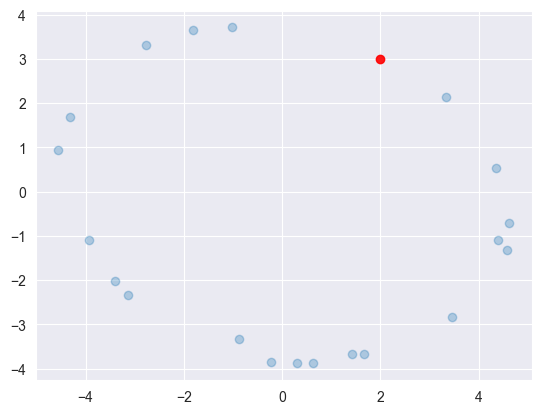

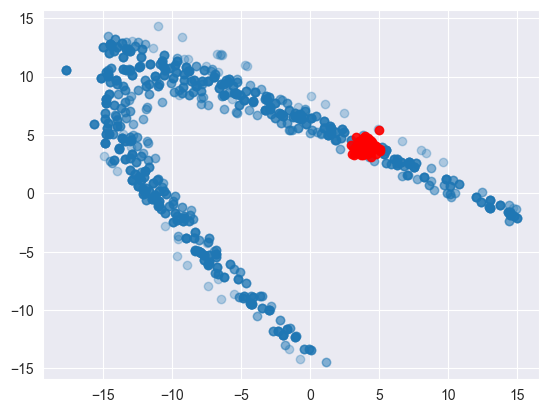

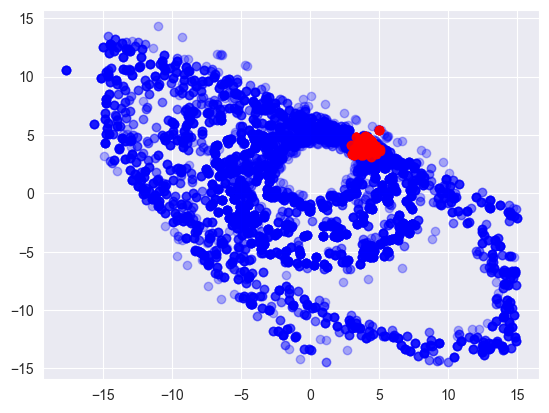

In [33]:
alpha=.3
plt.scatter(D_cal1[:,0], D_cal1[:,1], alpha=alpha)
plt.scatter(theta_true_c1[:,0],theta_true_c1[:,1], alpha=0.9,  c='r')
plt.show()

plt.scatter(D_cal2[:,0], D_cal2[:,1], alpha=alpha)
plt.scatter(theta_true_c2[:,0],theta_true_c2[:,1], alpha=0.9, c='r')
plt.show()

for Dcal in posterior_list:
    plt.scatter(Dcal[:,0], Dcal[:,1], alpha=alpha, c='b')
    plt.scatter(theta_true_c3[:,0],theta_true_c3[:,1], alpha=0.9,  c='r')
plt.show()

Reuse precomputed simulations (evaluate_model=False)

Build one big (θ, ξ) pool, then filter by ξ* to create per-design kNN indices


In [ ]:
from scipy.stats import gaussian_kde
posters = []
for xi in xi_list_c3:
    y_i = next(y for (y,x) in observations_c3 if np.isclose(x, xi))
    post_i = calib_comb.calibrate([(y_i, xi)], combine="stack", resample_n=1000)
    posters.append((xi, post_i["theta"]))

stack_all = np.vstack([th for _, th in posters] + [theta_true_cloud])
x_min, x_max = np.percentile(stack_all[:,0], [1, 99])
y_min, y_max = np.percentile(stack_all[:,1], [1, 99])
nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
grid = np.vstack([xx.ravel(), yy.ravel()])

zz = np.zeros((ny, nx))
for (c, (xi, th_xi)) in zip(colors, posters):
    kde = gaussian_kde(th_xi.T, bw_method='scott') # KDE on the posterior samples of this design
    zz_grid = kde(grid).reshape(ny, nx)
    zz += np.log(zz_grid)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
zz_lik = np.exp(zz)# filled contours + a thin outline
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1],
           c="r", marker="x", s=30, label="θ true cloud")  # true cloud on top

csf = ax.contourf(xx, yy, zz_lik, levels=8, alpha=0.3, antialiased=True)
ax.contour(xx, yy, zz_lik, levels=8, colors='b', linewidths=0.9)

ax.set_title("Per-design posterior densities (KDE) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.grid(True); ax.legend()
plt.show()
